In [2]:
import warnings
warnings.simplefilter("ignore")

import mlflow
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from simulation_study_analysis_helpers import *

# move to project root directory to find the mlruns folder with mlflow experiments
notebook_path = Path().resolve()
project_root = notebook_path.parent  # adjust as needed
os.chdir(project_root)

from simulation_studies.generate_synthetic_vine_data import generate_synthetic_vine_data

### Demo on how to analyse MLFlow Stored Experiments

1. Below we move to the root of the project where the mlruns folder is. There we can then call experiment wise run data. MLFlow allows us to look at tags, parameters as well as metrics in a pandas dataframe and hence create plots across runs. See minimal example below.

2. All Tags, Parameters, Metrics and Artifacts (Every Datatype, manely Plots and the Model) can also be viewed using the MLFlow User Interface which is a server you run locally. Simply open a new terminal and run "mlflow ui", then the server runs in that terminal and you can see it in the browser under "http://127.0.0.1:5000" (can be changed by a comand). Server can be closed by closing the terminal and running "pkill -f mlflow" in another terminal.

3. The only annoying thing about mlflow is that is uses absolute instead of relative paths. This means that if you want to analyze results created on another machine (server or another person) then it does not work. However I have coded a workaround that patches the paths. To solve this simply run the python script "/simulation_studies/mlflow_change_mlflow_artifact_directiories.py" in a terminal.


In [19]:
experiment_name = "rine_20D_500obs_bootstrap_hydra_fixed_copula_smaller_penlasso"
experiment = mlflow.get_experiment_by_name(experiment_name) 
df_runs = mlflow.search_runs([experiment.experiment_id])

# subset all runs seed smaller 32
df_runs = df_runs[df_runs["tags.seed_value"].astype(int) < 21]


df_structure = generate_synthetic_vine_data(seed_value=0,
                                            seed_value_copula=int(df_runs["tags.seed_value_copula"].iloc[0]),
                                            dimensionality=int(df_runs["tags.dimensionality"].iloc[0])
                                            )["df_true_structure"]

model fit to true distribution in original samples and bootstrap samples

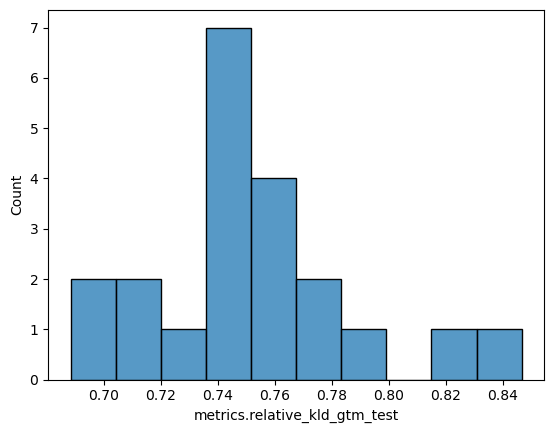

mean  0.7518904761904762
mode  0.7454


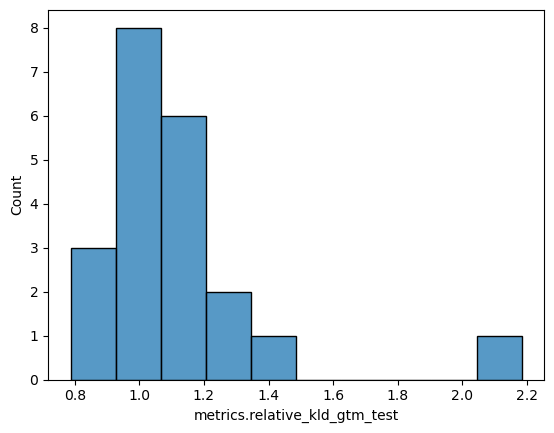

mean  1.123047619047619
mode  1.0581


In [4]:
bootstrap_bool = df_runs["tags.mlflow.runName"].str.contains("bootstrap")
df_run_originals_only = df_runs[~bootstrap_bool]


sns.histplot(data=df_run_originals_only, x="metrics.relative_kld_gtm_test")
plt.show()

print("mean ", df_run_originals_only["metrics.relative_kld_gtm_test"].mean())
print("mode ", df_run_originals_only["metrics.relative_kld_gtm_test"].quantile(0.5))

df_run_bootstrap_only = df_runs[bootstrap_bool]


sns.histplot(data=df_run_bootstrap_only, x="metrics.relative_kld_gtm_test")
plt.show()

print("mean ", df_run_bootstrap_only["metrics.relative_kld_gtm_test"].mean())
print("mode ", df_run_bootstrap_only["metrics.relative_kld_gtm_test"].quantile(0.5))

check out penalties chosen

(-5.0, 35.0)

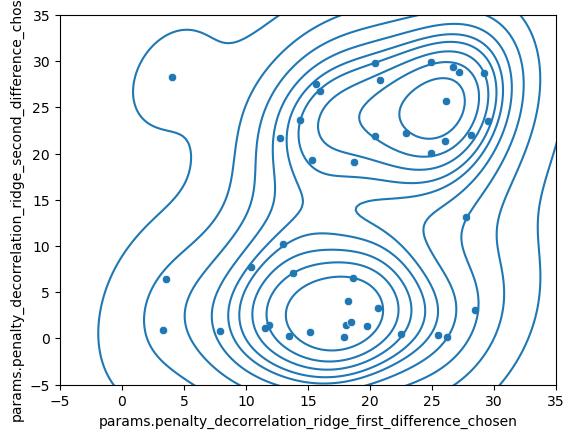

In [5]:
cols = [
    "params.penalty_decorrelation_ridge_first_difference_chosen",
    "params.penalty_decorrelation_ridge_second_difference_chosen",
]
df_runs[cols] = df_runs[cols].astype(float)

sns.kdeplot(data=df_runs, x="params.penalty_decorrelation_ridge_first_difference_chosen", y="params.penalty_decorrelation_ridge_second_difference_chosen")
sns.scatterplot(data=df_runs, x="params.penalty_decorrelation_ridge_first_difference_chosen", y="params.penalty_decorrelation_ridge_second_difference_chosen")
plt.ylim(-5,35)
plt.xlim(-5,35)

In [6]:
import torch
df_runs.loc[:, "params.penalty_lasso_conditional_independence_chosen"]

2       0.021589690819382668
3     5.6008280807873234e-05
4      6.904448355271597e-07
5        0.02814602106809616
6         0.9660914540290833
7     1.9289489500806667e-05
8       0.011638586409389973
9       0.000602366344537586
10      0.005127166397869587
11      0.032767314463853836
12       0.03455352410674095
13       0.06190594658255577
14     4.383499799587298e-06
15       0.06312074512243271
16       0.07668145000934601
17       0.05940523371100426
18        0.0848788470029831
19      0.046333614736795425
20      0.010847547091543674
21       0.17065641283988953
22     1.753188917064108e-05
23      0.006737889256328344
24       0.10534536093473434
25       0.02414354309439659
26     0.0008508741157129407
27       0.02770363725721836
28        0.0409640297293663
29      0.008643249981105328
30     0.0001565359125379473
31        0.0211305171251297
32     8.431320020463318e-05
33       0.06931190937757492
34      0.025559300556778908
35       0.07991590350866318
36      0.0069

## Training and Validation Samples based Analysis: Likelihood Ratio Statistic

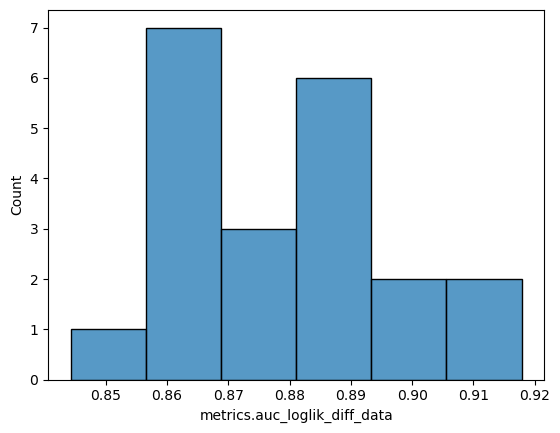

mean  0.8794862088979736
mode  0.8762762762762764


In [7]:
sns.histplot(data=df_run_originals_only, x="metrics.auc_loglik_diff_data")
plt.show()

print("mean ", df_run_originals_only["metrics.auc_loglik_diff_data"].mean())
print("mode ", df_run_originals_only["metrics.auc_loglik_diff_data"].quantile(0.5))

In [7]:
table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="training_and_validation")

In [8]:

df_structure = generate_synthetic_vine_data(seed_value=0,
                                            seed_value_copula=int(df_runs["tags.seed_value_copula"].iloc[0]),
                                            dimensionality=int(df_runs["tags.dimensionality"].iloc[0])
                                            )["df_true_structure"]

min_index=20
max_index=80

for key in list(table_original_dict.keys()):
    table_original_dict[key] = pd.DataFrame(table_original_dict[key].iloc[min_index:max_index])
    
df_structure.sort_values(by=['var_row', 'var_col'], inplace=True)
df_structure = df_structure.iloc[min_index:max_index]

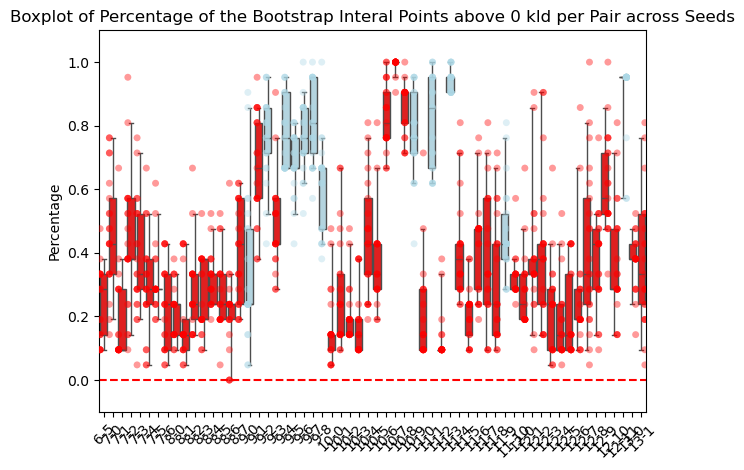

In [9]:
plot_metric_percentage_above_zero_bootstrap_intervals_across_seeds(df_runs,table_original_dict,table_diffs_list,df_structure,metric="kld")

In [10]:
#table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="training_and_validation")
#plot_metric_percentage_above_zero_bootstrap_intervals_across_seeds(df_runs,table_original_dict,table_diffs_list,df_structure,metric="kld")

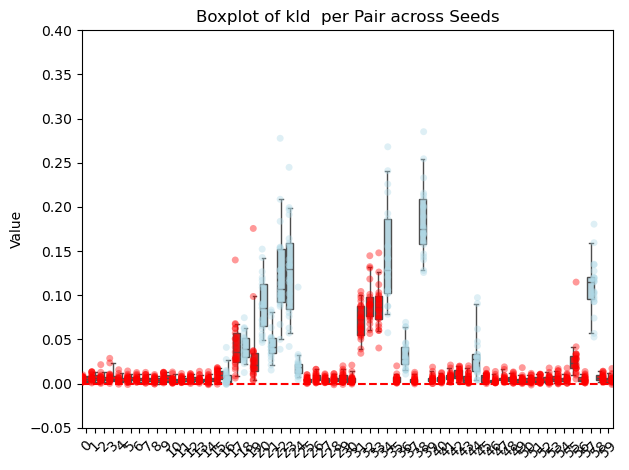

In [11]:
plot_metric_values_across_seeds(df_runs,table_original_dict,df_structure,metric="kld",ylim=(-0.05,0.4))

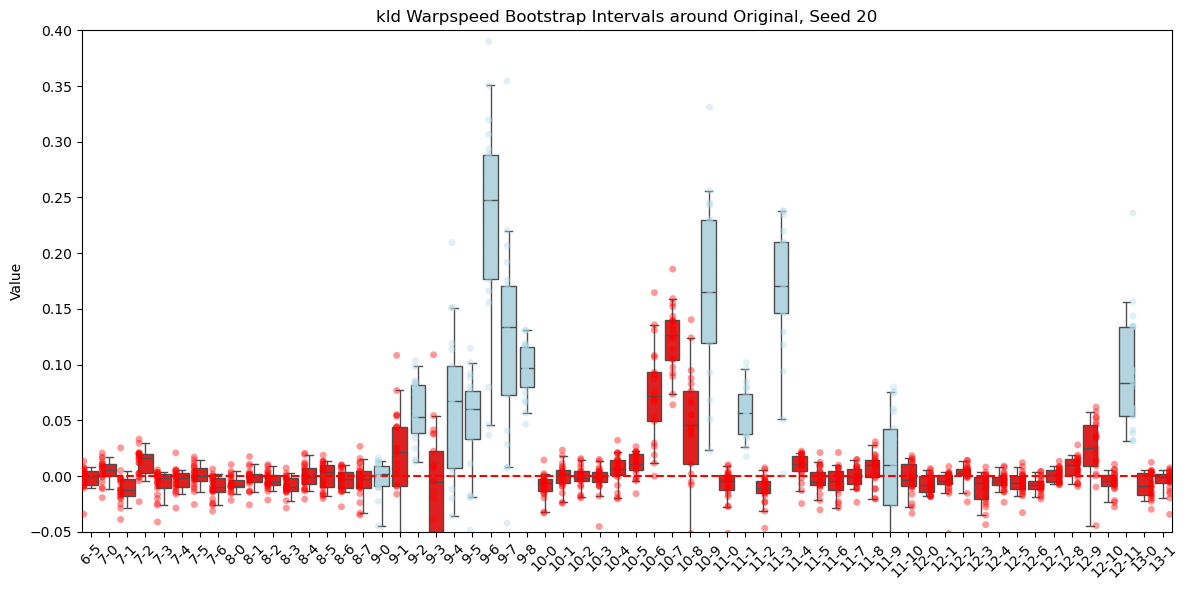

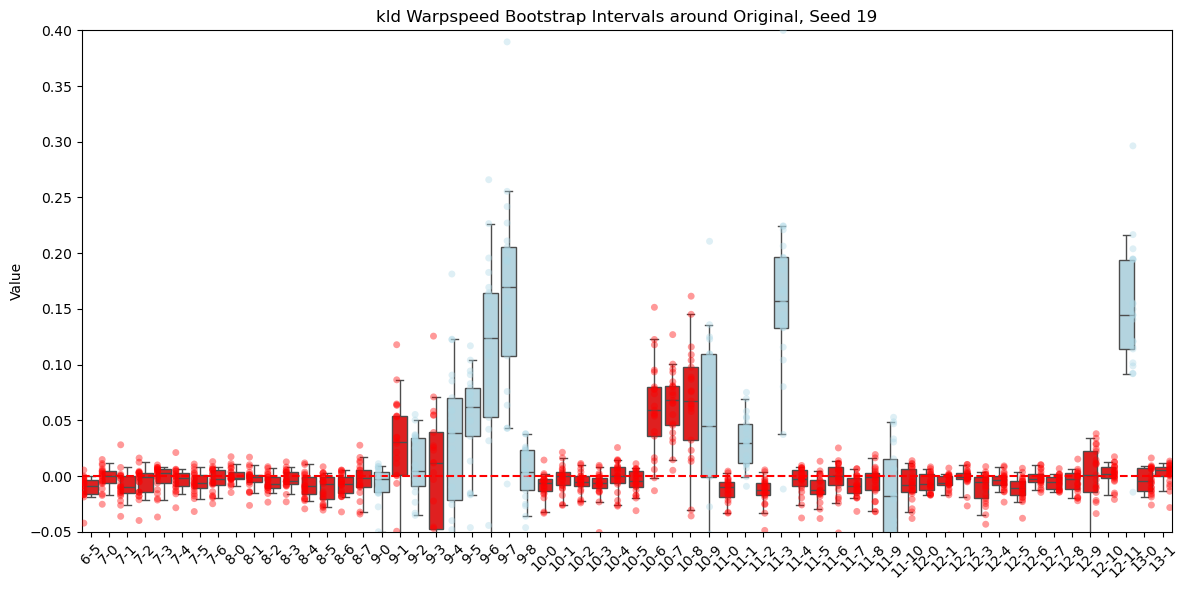

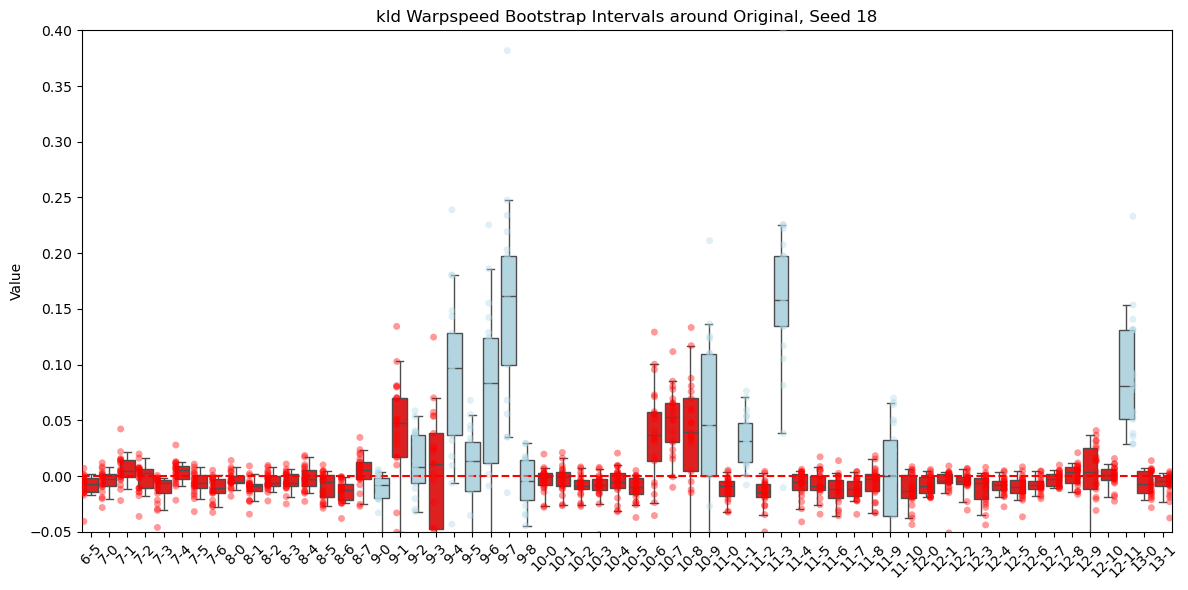

In [12]:
plot_metric_bootstrap_intervals_for_each_seed(df_runs[:6],table_original_dict,table_diffs_list,df_structure,metric="kld",ylim=(-0.05,0.4))

## Synthetic Samples based Analysis: IAE between estimated GTM and itsself under CI

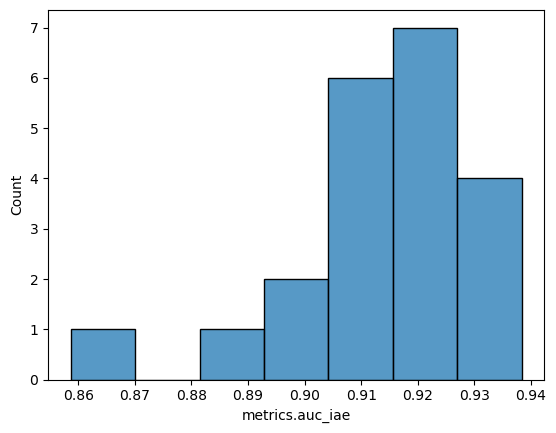

mean  0.913274619156972
mode  0.9157392686804451


In [13]:
sns.histplot(data=df_run_originals_only, x="metrics.auc_iae")
plt.show()

print("mean ", df_run_originals_only["metrics.auc_iae"].mean())
print("mode ", df_run_originals_only["metrics.auc_iae"].quantile(0.5))

In [14]:
table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="synthetic")

In [15]:

df_structure = generate_synthetic_vine_data(seed_value=0,
                                            seed_value_copula=int(df_runs["tags.seed_value_copula"].iloc[0]),
                                            dimensionality=int(df_runs["tags.dimensionality"].iloc[0])
                                            )["df_true_structure"]

min_index=20
max_index=80

for key in list(table_original_dict.keys()):
    table_original_dict[key] = pd.DataFrame(table_original_dict[key].iloc[min_index:max_index])
    
df_structure.sort_values(by=['var_row', 'var_col'], inplace=True)
df_structure = df_structure.iloc[min_index:max_index]

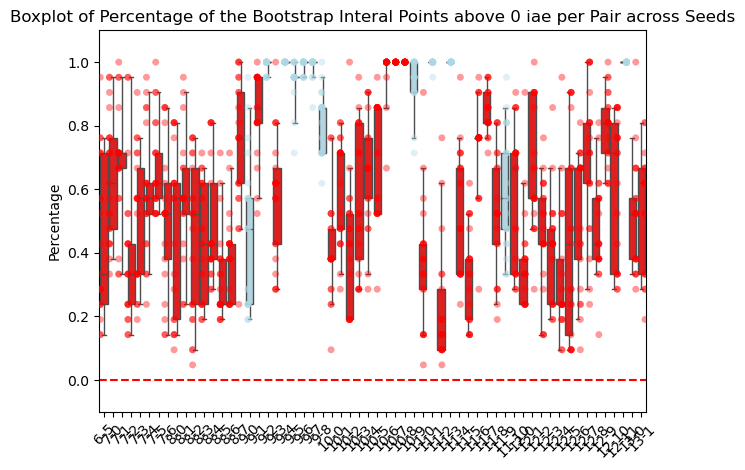

In [16]:
plot_metric_percentage_above_zero_bootstrap_intervals_across_seeds(df_runs,table_original_dict,table_diffs_list,df_structure,metric="iae")

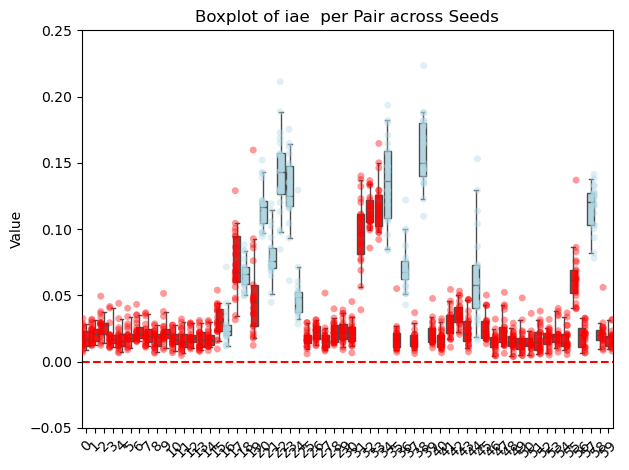

In [17]:
plot_metric_values_across_seeds(df_runs,table_original_dict,df_structure,metric="iae",ylim=(-0.05,0.25))

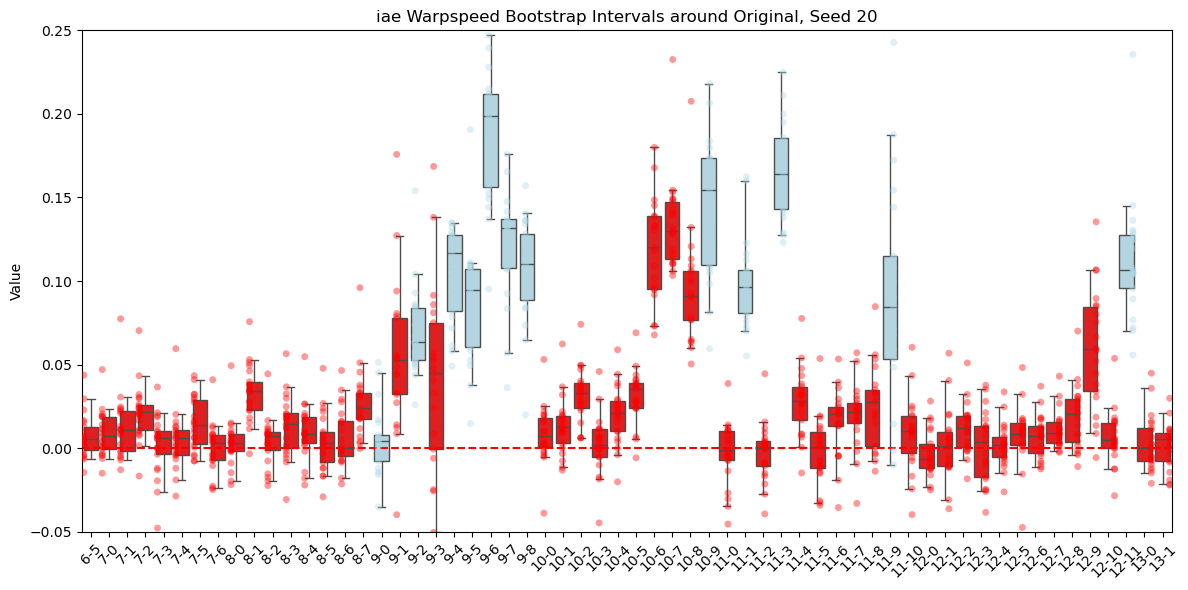

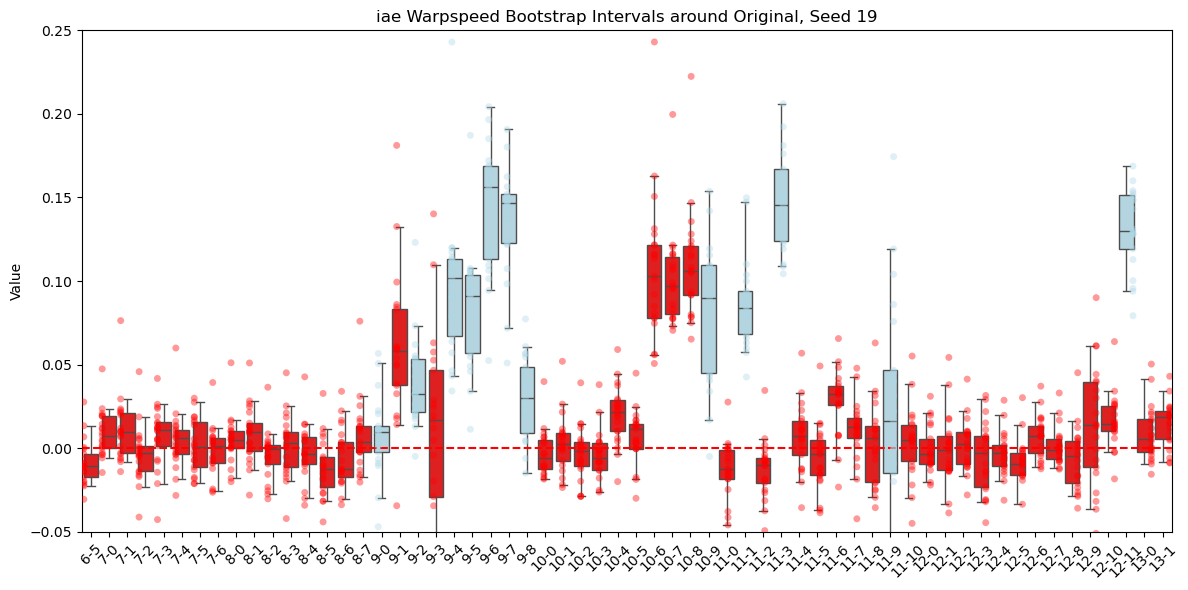

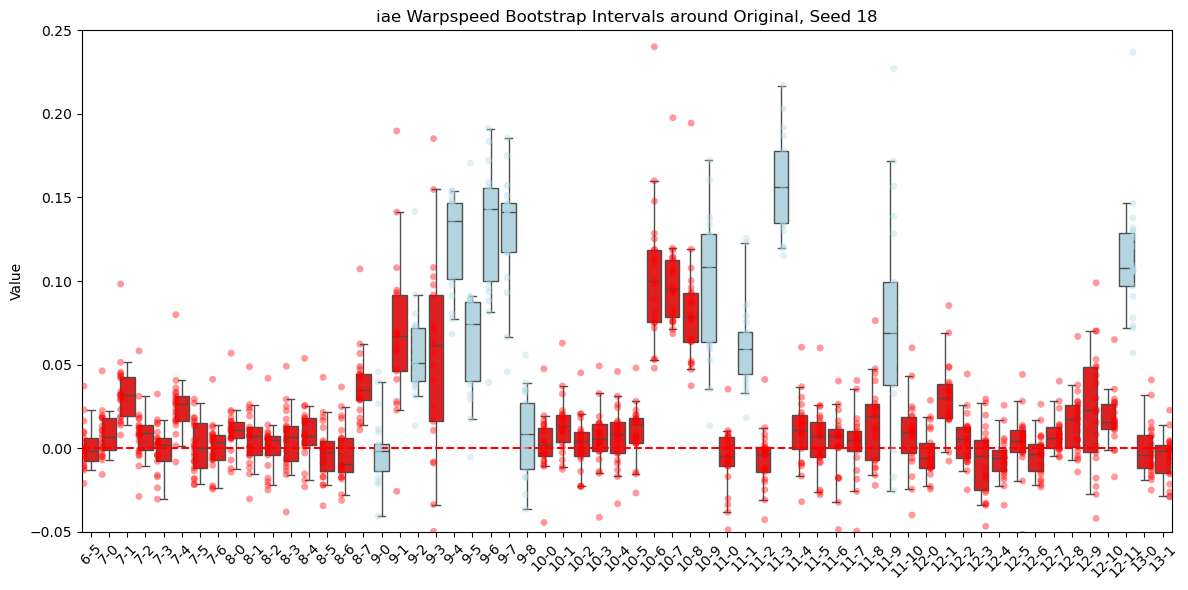

In [18]:
plot_metric_bootstrap_intervals_for_each_seed(df_runs[:6],table_original_dict,table_diffs_list,df_structure,metric="iae")

In [21]:
table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="synthetic")

In [33]:
table_original_dict['20'].loc[:,"iae"]

0      0.032751
1      0.029696
2      0.024893
3      0.021721
4      0.049825
         ...   
185    0.030676
186    0.098321
187    0.148208
188    0.021655
189    0.185050
Name: iae, Length: 190, dtype: float64

In [37]:
table_original_dict['20'].loc[:,"iae"].mean()

0.05155482136423843

In [9]:
table_original_dict[key]

,index,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae
0,20.0,1.0,0.0,0.127946,0.019434,0.111263,0.014573,0.009120,0.029358
1,40.0,2.0,0.0,0.091103,0.011273,0.082720,0.009383,0.010356,0.026076
2,41.0,2.0,1.0,0.051075,0.004962,0.042435,0.003416,0.009696,0.022598
3,60.0,3.0,0.0,0.060604,0.005302,0.050508,0.003613,0.009293,0.019969
4,61.0,3.0,1.0,0.191537,0.041472,0.149866,0.024737,0.012961,0.042770
...,...,...,...,...,...,...,...,...,...
185,394.0,19.0,14.0,0.090859,0.011810,0.053341,0.004130,0.008754,0.024569
186,395.0,19.0,15.0,0.577461,0.359274,0.176750,0.033764,0.086254,0.085483
187,396.0,19.0,16.0,1.060551,1.355983,0.411293,0.196215,0.146113,0.119879
188,397.0,19.0,17.0,0.077241,0.007895,0.047471,0.003000,0.005273,0.017349


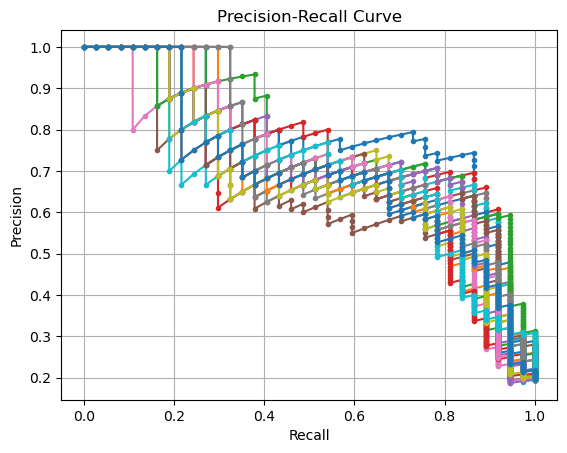

In [17]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="training_and_validation")

df_structure = generate_synthetic_vine_data(seed_value=0,
                                            seed_value_copula=int(df_runs["tags.seed_value_copula"].iloc[0]),
                                            dimensionality=int(df_runs["tags.dimensionality"].iloc[0])
                                            )["df_true_structure"]
df_structure.sort_values(by=['var_row', 'var_col'], inplace=True)

for key in list(table_original_dict.keys()):
    
    table_original_dict[key].sort_values(by=['var_row', 'var_col'], inplace=True)

    precision, recall, thresholds = precision_recall_curve(df_structure.loc[:,"dependence"], 
                                                        table_original_dict[key].loc[:,"kld"])

    plt.plot(recall, precision, marker=".")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

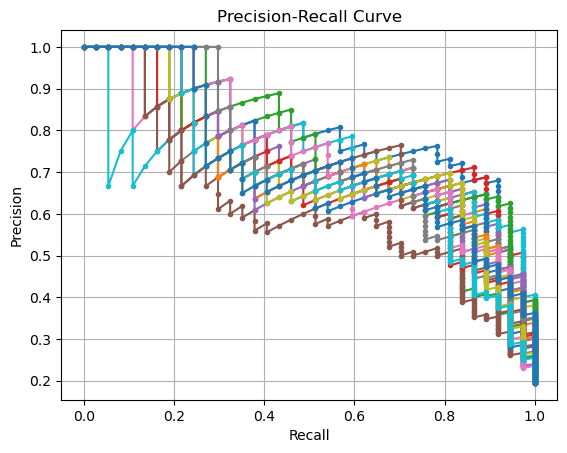

In [16]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="synthetic")

df_structure = generate_synthetic_vine_data(seed_value=0,
                                            seed_value_copula=int(df_runs["tags.seed_value_copula"].iloc[0]),
                                            dimensionality=int(df_runs["tags.dimensionality"].iloc[0])
                                            )["df_true_structure"]
df_structure.sort_values(by=['var_row', 'var_col'], inplace=True)

for key in list(table_original_dict.keys()):
    
    table_original_dict[key].sort_values(by=['var_row', 'var_col'], inplace=True)

    precision, recall, thresholds = precision_recall_curve(df_structure.loc[:,"dependence"], 
                                                        table_original_dict[key].loc[:,"iae"])

    plt.plot(recall, precision, marker=".")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

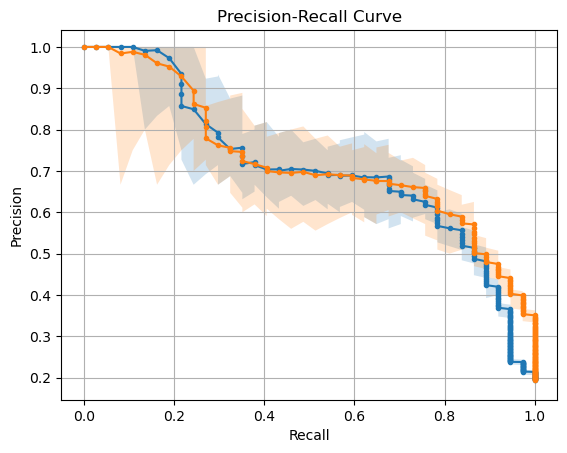

In [20]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="training_and_validation")

df_structure = generate_synthetic_vine_data(seed_value=0,
                                            seed_value_copula=int(df_runs["tags.seed_value_copula"].iloc[0]),
                                            dimensionality=int(df_runs["tags.dimensionality"].iloc[0])
                                            )["df_true_structure"]
df_structure.sort_values(by=['var_row', 'var_col'], inplace=True)

counter=0
for key in list(table_original_dict.keys()):
    
    table_original_dict[key].sort_values(by=['var_row', 'var_col'], inplace=True)

    precision, recall, thresholds = precision_recall_curve(df_structure.loc[:,"dependence"], 
                                                        table_original_dict[key].loc[:,"kld"])

    if counter == 0:
        precision_total = precision.reshape(1,191)
        #recall_total = recall
        counter=1
    else:
        precision_total = np.concatenate((precision_total,precision.reshape(1,191)),axis=0)
        #recall_total = np.stack((recall_total,recall),axis=0)


mean_precision = np.mean(precision_total, axis=0)
lower = np.min(precision_total, axis=0) #np.percentile(precision_total, 0, axis=0)
upper = np.max(precision_total, axis=0) #np.percentile(precision_total, 100, axis=0)

    
# ---- Plot mean and fill between confidence interval ----
plt.plot(recall, mean_precision, marker=".", label=key)
plt.fill_between(recall, lower, upper, alpha=0.2)

#####################################################################################################################################################

table_diffs_list, table_original_dict = get_data_original_and_bootstrap(df_runs,data="synthetic")

df_structure = generate_synthetic_vine_data(seed_value=0,
                                            seed_value_copula=int(df_runs["tags.seed_value_copula"].iloc[0]),
                                            dimensionality=int(df_runs["tags.dimensionality"].iloc[0])
                                            )["df_true_structure"]
df_structure.sort_values(by=['var_row', 'var_col'], inplace=True)

counter=0
for key in list(table_original_dict.keys()):
    
    table_original_dict[key].sort_values(by=['var_row', 'var_col'], inplace=True)

    precision, recall, thresholds = precision_recall_curve(df_structure.loc[:,"dependence"], 
                                                        table_original_dict[key].loc[:,"iae"])

    if counter == 0:
        precision_total = precision.reshape(1,191)
        #recall_total = recall
        counter=1
    else:
        precision_total = np.concatenate((precision_total,precision.reshape(1,191)),axis=0)
        #recall_total = np.stack((recall_total,recall),axis=0)


mean_precision = np.mean(precision_total, axis=0)
lower = np.min(precision_total, axis=0) #np.percentile(precision_total, 0, axis=0)
upper = np.max(precision_total, axis=0) #np.percentile(precision_total, 100, axis=0)

    
# ---- Plot mean and fill between confidence interval ----
plt.plot(recall, mean_precision, marker=".", label=key)
plt.fill_between(recall, lower, upper, alpha=0.2)


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()